In [57]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

## Load the excel file into a dataframe 

In [58]:
#df = pd.read_excel("IWA.xlsx", sheet_name='Final Raw Sample(3%)')
df = pd.read_excel("IWA.xlsx", sheet_name='Final Raw Sample(0%)')
df["Revenue"] = df["Total Environmental Cost"]/df["Environmental Intensity (Sales)"]
df["Operating Income"] = df["Total Environmental Cost"]/df["Environmental Intensity (Op Inc)"]
df["Environmental Intensity (Op Inc)"] = df["Environmental Intensity (Op Inc)"]*100
df["Environmental Intensity (Sales)"] = df["Environmental Intensity (Sales)"]*100
df.dropna()
df.head()

,Year,Company Name,Country,GICS Sub-Industry,Industry (Exiobase),Environmental Intensity (Sales),Environmental Intensity (Op Inc),Total Environmental Cost,Working Capacity,Fish Production Capacity,...,SDG 14.1,SDG 14.2,SDG 14.3,SDG 14.c,SDG 15.1,SDG 15.2,SDG 15.5,% Imputed,Revenue,Operating Income
0,2019,SAGA PLC,UNITED KINGDOM OF GREAT BRITAIN AND NORTHERN I...,Multi-line Insurance,Activities auxiliary to financial intermediati...,-2.887178,-13.025357,-3.184231e+07,-3.115075e+07,-7184.203318,...,-4.739468,-1.027193,-3584.970569,-5.649112,70.667599,70.667599,-1297.277948,0.006135,1.102887e+09,244464000.0
1,2019,BURSA MALAYSIA BHD,MALAYSIA,Financial Exchanges & Data,Activities auxiliary to financial intermediati...,-1.677157,-3.465639,-1.968379e+06,-1.924910e+06,-451.342112,...,-1.410813,-1.207108,-222.196310,-1.681590,10.138780,10.138780,-79.398691,0.043215,1.173640e+08,56797000.0
2,2019,INTERTEK GROUP PLC,UNITED KINGDOM OF GREAT BRITAIN AND NORTHERN I...,Research & Consulting Services,Activities auxiliary to financial intermediati...,-1.529690,-9.487849,-6.059927e+07,-5.928166e+07,-13774.014902,...,-17.024036,-3.689647,-6861.392776,-20.291452,253.836024,253.836024,-2470.054721,0.011467,3.961539e+09,638704000.0
3,2019,JSE LIMITED,SOUTH AFRICA,Financial Exchanges & Data,Activities auxiliary to financial intermediati...,-1.462497,NaN,-2.290124e+06,-2.239814e+06,-510.210093,...,-0.189720,-1.009642,-253.366805,-0.226133,-3.169102,-3.169102,-92.619013,0.016390,1.565900e+08,NaN
4,2019,BUREAU VERITAS SA,FRANCE,Research & Consulting Services,Activities auxiliary to financial intermediati...,-0.699273,-5.095678,-3.997865e+07,-3.910761e+07,-9330.459280,...,-37.818819,-9.136488,-4606.916825,-45.077368,586.030400,586.030400,-1632.997165,0.033005,5.717172e+09,784560000.0


## Filter out the outliers in the data

In [59]:
Q1 = df['Environmental Intensity (Op Inc)'].quantile(0.25)
Q3 = df['Environmental Intensity (Op Inc)'].quantile(0.75)

# Calculate the IQR (Interquartile Range)
IQR = Q3 - Q1

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter outliers based on the IQR method
df_cleaned = df[(df['Environmental Intensity (Op Inc)'] >= lower_bound) & (df['Environmental Intensity (Op Inc)'] <= upper_bound)]


## Function to run the Categorical Fixed Effects and return the r squared value

In [60]:
def runFixedEffects(X, y, df_selected, list_effectNames):
    list_df_Effects = list()

    # Create as list of the dummy variables for the fixed effects 
    for columnName in list_effectNames:
        df_temp = pd.get_dummies(df_selected[columnName], drop_first=True)
        df_temp = df_temp.astype(int)
        list_df_Effects.append(df_temp)
    
    # Add the dummies to the independent variables
    X = pd.concat(list_df_Effects, axis=1)
    # Add a constant (intercept) to the independent variables
    X = sm.add_constant(X)
    
    # Fit the OLS model
    model = sm.OLS(y, X).fit() 
    
    # Calculate  and return the adjusted R-squared
    adjusted_r_squared = 1 - (1 - model.rsquared) * (len(y) - 1) / (len(y) - X.shape[1] - 1)
    
    return adjusted_r_squared, model.summary()

## setup which dependent and independent variables to use

In [61]:
harvard_set = ["Working Capacity", "Fish Production Capacity", "Crop Production Capacity",
                      "Meat Production Capacity", "Biodiversity", "Abiotic Resources",
                      "Water production capacity (Drinking water & Irrigation Water)", "Wood Production Capacity"]

sdg_set = ["SDG 1.5", "SDG 2.1", "SDG 2.2", "SDG 2.3", "SDG 2.4", "SDG 3.3", 
                         "SDG 3.4", "SDG 3.9", "SDG 6", "SDG 12.2", "SDG 14.1", "SDG 14.2", 
                         "SDG 14.3", "SDG 14.c", "SDG 15.1", "SDG 15.2", "SDG 15.5"]

independentVariables = harvard_set

In [62]:
y_sales = df_cleaned["Environmental Intensity (Sales)"]
y_opinc = df_cleaned["Environmental Intensity (Op Inc)"]
X = df_cleaned[independentVariables]

d_RSquaredAll = {}
l_RsquaredForEffect = []

## Fixed Effect: Year
#### sales

In [63]:
list_effectNames = ['Year']
adjusted_r_squared, year_summary = runFixedEffects(X,y_sales,df_cleaned, list_effectNames)
print(f'Adjusted R-squared (Fixed on Year): {adjusted_r_squared:.6f}')
print(year_summary)

l_RsquaredForEffect = [adjusted_r_squared]

Adjusted R-squared (Fixed on Year): 0.000044
                                   OLS Regression Results                                  
Dep. Variable:     Environmental Intensity (Sales)   R-squared:                       0.001
Model:                                         OLS   Adj. R-squared:                  0.000
Method:                              Least Squares   F-statistic:                     1.166
Date:                             Wed, 04 Oct 2023   Prob (F-statistic):              0.312
Time:                                     14:56:13   Log-Likelihood:                -38493.
No. Observations:                            11234   AIC:                         7.701e+04
Df Residuals:                                11224   BIC:                         7.708e+04
Df Model:                                        9                                         
Covariance Type:                         nonrobust                                         
                 coef    std err   

#### op income

In [64]:
list_effectNames = ['Year']
adjusted_r_squared, year_summary = runFixedEffects(X,y_opinc,df_cleaned, list_effectNames)
print(f'Adjusted R-squared (Fixed on Year): {adjusted_r_squared:.6f}')
print(year_summary)

l_RsquaredForEffect.append(adjusted_r_squared)
d_RSquaredAll['Year'] = l_RsquaredForEffect

Adjusted R-squared (Fixed on Year): -0.000587
                                   OLS Regression Results                                   
Dep. Variable:     Environmental Intensity (Op Inc)   R-squared:                       0.000
Model:                                          OLS   Adj. R-squared:                 -0.000
Method:                               Least Squares   F-statistic:                    0.3785
Date:                              Wed, 04 Oct 2023   Prob (F-statistic):              0.946
Time:                                      14:56:13   Log-Likelihood:                -59381.
No. Observations:                             11234   AIC:                         1.188e+05
Df Residuals:                                 11224   BIC:                         1.189e+05
Df Model:                                         9                                         
Covariance Type:                          nonrobust                                         
                 coef   

## Fixed Effect: Country
#### sales

In [65]:
list_effectNames = ['Country']
adjusted_r_squared, country_summary = runFixedEffects(X,y_sales,df_cleaned, list_effectNames)
print(f'Adjusted R-squared (Fixed on Year): {adjusted_r_squared:.6f}')
print(country_summary)

l_RsquaredForEffect = [adjusted_r_squared]

Adjusted R-squared (Fixed on Year): 0.085981
                                   OLS Regression Results                                  
Dep. Variable:     Environmental Intensity (Sales)   R-squared:                       0.091
Model:                                         OLS   Adj. R-squared:                  0.086
Method:                              Least Squares   F-statistic:                     17.53
Date:                             Wed, 04 Oct 2023   Prob (F-statistic):          9.02e-183
Time:                                     14:56:13   Log-Likelihood:                -37961.
No. Observations:                            11234   AIC:                         7.605e+04
Df Residuals:                                11169   BIC:                         7.653e+04
Df Model:                                       64                                         
Covariance Type:                         nonrobust                                         
                                   

#### op income

In [66]:
list_effectNames = ['Country']
adjusted_r_squared, country_summary = runFixedEffects(X,y_opinc,df_cleaned, list_effectNames)
print(f'Adjusted R-squared (Fixed on Year): {adjusted_r_squared:.6f}')
print(country_summary)

l_RsquaredForEffect.append(adjusted_r_squared)
d_RSquaredAll['Country'] = l_RsquaredForEffect

Adjusted R-squared (Fixed on Year): 0.054201
                                   OLS Regression Results                                   
Dep. Variable:     Environmental Intensity (Op Inc)   R-squared:                       0.060
Model:                                          OLS   Adj. R-squared:                  0.054
Method:                               Least Squares   F-statistic:                     11.07
Date:                              Wed, 04 Oct 2023   Prob (F-statistic):          1.39e-105
Time:                                      14:56:13   Log-Likelihood:                -59037.
No. Observations:                             11234   AIC:                         1.182e+05
Df Residuals:                                 11169   BIC:                         1.187e+05
Df Model:                                        64                                         
Covariance Type:                          nonrobust                                         
                         

## Fixed Effect: Year and GICS Sub-Industry
#### sales

In [67]:
list_effectNames = ['Year', 'GICS Sub-Industry']
adjusted_r_squared, yearGICS_summary = runFixedEffects(X,y_sales,df_cleaned, list_effectNames)
print(f'Adjusted R-squared (Fixed on Year and GICS Sub-Industry): {adjusted_r_squared:.4f}')
print(yearGICS_summary)

l_RsquaredForEffect = [adjusted_r_squared]

Adjusted R-squared (Fixed on Year and GICS Sub-Industry): 0.3995
                                   OLS Regression Results                                  
Dep. Variable:     Environmental Intensity (Sales)   R-squared:                       0.408
Model:                                         OLS   Adj. R-squared:                  0.400
Method:                              Least Squares   F-statistic:                     49.21
Date:                             Wed, 04 Oct 2023   Prob (F-statistic):               0.00
Time:                                     14:56:13   Log-Likelihood:                -35556.
No. Observations:                            11234   AIC:                         7.142e+04
Df Residuals:                                11078   BIC:                         7.257e+04
Df Model:                                      155                                         
Covariance Type:                         nonrobust                                         
               

#### op income

In [68]:
list_effectNames = ['Year', 'GICS Sub-Industry']
adjusted_r_squared, yearGICS_summary = runFixedEffects(X,y_opinc,df_cleaned, list_effectNames)
print(f'Adjusted R-squared (Fixed on Year and GICS Sub-Industry): {adjusted_r_squared:.4f}')
print(yearGICS_summary)

l_RsquaredForEffect.append(adjusted_r_squared)
d_RSquaredAll['Year + GICS Sub-Industry'] = l_RsquaredForEffect

Adjusted R-squared (Fixed on Year and GICS Sub-Industry): 0.4150
                                   OLS Regression Results                                   
Dep. Variable:     Environmental Intensity (Op Inc)   R-squared:                       0.423
Model:                                          OLS   Adj. R-squared:                  0.415
Method:                               Least Squares   F-statistic:                     52.42
Date:                              Wed, 04 Oct 2023   Prob (F-statistic):               0.00
Time:                                      14:56:14   Log-Likelihood:                -56293.
No. Observations:                             11234   AIC:                         1.129e+05
Df Residuals:                                 11078   BIC:                         1.140e+05
Df Model:                                       155                                         
Covariance Type:                          nonrobust                                         
     

## Fixed Effect: Year and Industry (Exiobase)
#### sales

In [69]:
list_effectNames = ['Year', 'Industry (Exiobase)']
adjusted_r_squared, yearIndustry_summary = runFixedEffects(X,y_sales,df_cleaned, list_effectNames)
print(f'Adjusted R-squared (Fixed on Year and Industry (Exiobase)): {adjusted_r_squared:.4f}')
print(yearIndustry_summary)

l_RsquaredForEffect = [adjusted_r_squared]

Adjusted R-squared (Fixed on Year and Industry (Exiobase)): 0.3108
                                   OLS Regression Results                                  
Dep. Variable:     Environmental Intensity (Sales)   R-squared:                       0.315
Model:                                         OLS   Adj. R-squared:                  0.311
Method:                              Least Squares   F-statistic:                     84.08
Date:                             Wed, 04 Oct 2023   Prob (F-statistic):               0.00
Time:                                     14:56:14   Log-Likelihood:                -36376.
No. Observations:                            11234   AIC:                         7.288e+04
Df Residuals:                                11172   BIC:                         7.333e+04
Df Model:                                       61                                         
Covariance Type:                         nonrobust                                         
             

#### op income

In [70]:
list_effectNames = ['Year', 'Industry (Exiobase)']
adjusted_r_squared, yearIndustry_summary = runFixedEffects(X,y_opinc,df_cleaned, list_effectNames)
print(f'Adjusted R-squared (Fixed on Year and Industry (Exiobase)): {adjusted_r_squared:.4f}')
print(yearIndustry_summary)

l_RsquaredForEffect.append(adjusted_r_squared)
d_RSquaredAll['Year + Industry (Exiobase)'] = l_RsquaredForEffect

Adjusted R-squared (Fixed on Year and Industry (Exiobase)): 0.3334
                                   OLS Regression Results                                   
Dep. Variable:     Environmental Intensity (Op Inc)   R-squared:                       0.337
Model:                                          OLS   Adj. R-squared:                  0.333
Method:                               Least Squares   F-statistic:                     93.13
Date:                              Wed, 04 Oct 2023   Prob (F-statistic):               0.00
Time:                                      14:56:14   Log-Likelihood:                -57074.
No. Observations:                             11234   AIC:                         1.143e+05
Df Residuals:                                 11172   BIC:                         1.147e+05
Df Model:                                        61                                         
Covariance Type:                          nonrobust                                         
   

## Fixed Effect: Year, GICS Sub-Industry, and Country
#### sales

In [71]:
list_effectNames = ['Year', 'GICS Sub-Industry', 'Country']
adjusted_r_squared, yearGICSCountry_summary = runFixedEffects(X,y_sales,df_cleaned, list_effectNames)
print(f'Adjusted R-squared (Fixed on Year, GICS Sub-Industry and Country): {adjusted_r_squared:.4f}')
print(yearGICSCountry_summary)

l_RsquaredForEffect = [adjusted_r_squared]

Adjusted R-squared (Fixed on Year, GICS Sub-Industry and Country): 0.4488
                                   OLS Regression Results                                  
Dep. Variable:     Environmental Intensity (Sales)   R-squared:                       0.460
Model:                                         OLS   Adj. R-squared:                  0.449
Method:                              Least Squares   F-statistic:                     42.77
Date:                             Wed, 04 Oct 2023   Prob (F-statistic):               0.00
Time:                                     14:56:14   Log-Likelihood:                -35042.
No. Observations:                            11234   AIC:                         7.052e+04
Df Residuals:                                11014   BIC:                         7.214e+04
Df Model:                                      219                                         
Covariance Type:                         nonrobust                                         
      

#### op income

In [72]:
list_effectNames = ['Year', 'GICS Sub-Industry', 'Country']
adjusted_r_squared, yearGICSCountry_summary = runFixedEffects(X,y_opinc,df_cleaned, list_effectNames)
print(f'Adjusted R-squared (Fixed on Year, GICS Sub-Industry and Country): {adjusted_r_squared:.4f}')
print(yearGICSCountry_summary)

l_RsquaredForEffect.append(adjusted_r_squared)
d_RSquaredAll['Year + GICS Sub-Industry + Country'] = l_RsquaredForEffect

Adjusted R-squared (Fixed on Year, GICS Sub-Industry and Country): 0.4489
                                   OLS Regression Results                                   
Dep. Variable:     Environmental Intensity (Op Inc)   R-squared:                       0.460
Model:                                          OLS   Adj. R-squared:                  0.449
Method:                               Least Squares   F-statistic:                     42.79
Date:                              Wed, 04 Oct 2023   Prob (F-statistic):               0.00
Time:                                      14:56:15   Log-Likelihood:                -55925.
No. Observations:                             11234   AIC:                         1.123e+05
Df Residuals:                                 11014   BIC:                         1.139e+05
Df Model:                                       219                                         
Covariance Type:                          nonrobust                                      

In [81]:
d_RSquaredAll

{'Year': [4.3500736056301115e-05, -0.0005873486065151035],
 'Country': [0.0859806858663954, 0.05420075246062794],
 'Year + GICS Sub-Industry': [0.39945282298873885, 0.41500178700252144],
 'Year + Industry (Exiobase)': [0.3108397110638276, 0.3334074389837183],
 'Year + GICS Sub-Industry + Country': [0.4487707359182215,
  0.44893707934761307]}

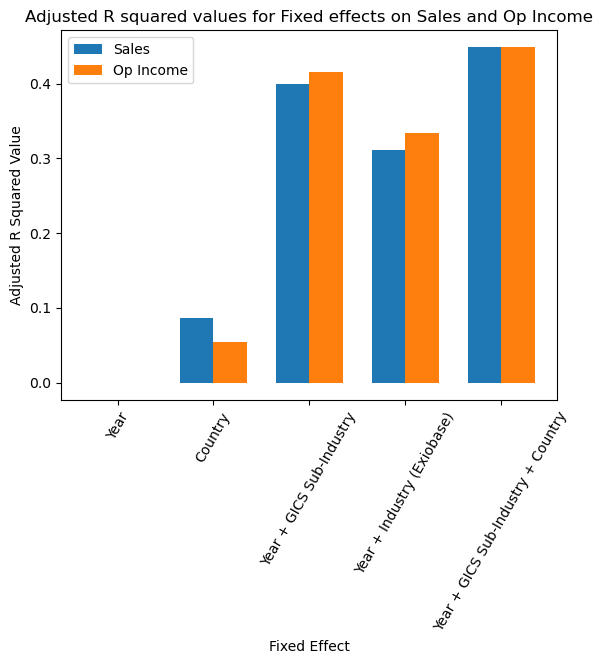

In [78]:
# Extract category names and values
categories = list(d_RSquaredAll.keys())
onSales = [value[0] for value in d_RSquaredAll.values()]
onOpIncome = [value[1] for value in d_RSquaredAll.values()]

# Set the width of the bars
bar_width = 0.35

# Create the X-axis values for the bar groups
x = range(len(categories))

# Create the bar plots for fixed effect on sale and on operating income
plt.bar(x, onSales, width=bar_width, label='Sales')
plt.bar([i + bar_width for i in x], onOpIncome, width=bar_width, label='Op Income')

# Label the X-axis with category names
plt.xlabel('Fixed Effect')
plt.xticks([i + bar_width/2 for i in x], categories, rotation=60)

# Label the Y-axis
plt.ylabel('Adjusted R Squared Value')

# Add a legend
plt.legend()

# Set the title
plt.title('Adjusted R squared values for Fixed effects on Sales and Op Income')

# Show the plot
plt.show()

## Same effects but only the brewers

In [15]:
df_GICSBrew = df_cleaned[df_cleaned['GICS Sub-Industry'] == 'Brewers']

# Group the data by "Company Name" and count unique years for each group
#company_years_count = df_GICSBrew.groupby("Company Name")["Year"].nunique()

# Filter companies with at least 10 years of data
#filtered_companies = company_years_count[company_years_count >= 10].index

# Create a new DataFrame with only the companies that meet the criteria
#df_GICSBrewFiltered = df_GICSBrew[df_GICSBrew["Company Name"].isin(filtered_companies)]
df_GICSBrewFiltered = df_GICSBrew
df_GICSBrewFiltered.head()

,Year,Company Name,Country,GICS Sub-Industry,Industry (Exiobase),Environmental Intensity (Sales),Environmental Intensity (Op Inc),Total Environmental Cost,Working Capacity,Fish Production Capacity,...,SDG 14.1,SDG 14.2,SDG 14.3,SDG 14.c,SDG 15.1,SDG 15.2,SDG 15.5,% Imputed,Revenue,Operating Income
516,2019,BUDWEISER BREWING CO,CAYMAN ISLANDS,Brewers,Manufacture of beverages,-7.019612,-37.638941,-4.620955e+08,-2.100877e+08,-50971.941181,...,-140.450129,-28.052546,-25278.227923,-167.406661,1886.414782,1886.414782,-8773.429720,0.017490,6.582921e+09,1.227706e+09
517,2019,MOLSON COORS BEVERAGE CO,UNITED STATES OF AMERICA,Brewers,Manufacture of beverages,-6.596233,-46.522794,-6.978419e+08,-2.950986e+08,-77656.206578,...,-1113.208360,-326.988191,-37024.568588,-1326.865949,15176.840942,15176.840942,-12261.768244,0.059202,1.057940e+10,1.500000e+09
519,2019,COMPANIA CERVECERIAS UNIDAS,CHILE,Brewers,Manufacture of beverages,-6.415653,-54.146661,-1.555141e+08,-5.966586e+07,-13149.956614,...,-104.142317,-467.109898,-5751.475432,-124.130306,-1430.679992,-55213.362037,-2224.738635,0.084882,2.423979e+09,2.872090e+08
523,2019,ANHEUSER-BUSCH INBEV,BELGIUM,Brewers,Manufacture of beverages,-3.388736,-11.492977,-1.778566e+09,-1.561186e+09,-391750.191978,...,-3914.291085,-325.789140,-190769.424529,-4665.559245,56659.806086,56659.806086,-64862.799133,0.080199,5.248464e+10,1.547524e+10
526,2019,CARLSBERG A/S,DENMARK,Brewers,Manufacture of beverages,-2.414563,-16.054846,-2.388141e+08,-1.962082e+08,-60262.712495,...,-1480.449400,-288.844325,-27951.868900,-1764.591400,19253.589023,19132.282417,-8148.334758,0.029599,9.890572e+09,1.487489e+09


In [18]:
y_brew_sales = df_GICSBrewFiltered["Environmental Intensity (Sales)"]
y_brew_opinc = df_GICSBrewFiltered["Environmental Intensity (Op Inc)"]
X_brew = df_GICSBrewFiltered[independentVariables]

In [21]:
list_effectNames = ['Year']
adjusted_r_squared, year_summary = runFixedEffects(X_brew,y_brew_sales,df_GICSBrewFiltered, list_effectNames)
print(f'Adjusted R-squared (Fixed on Year): {adjusted_r_squared:.6f}')
print(year_summary)

Adjusted R-squared (Fixed on Year): -0.062483
                                   OLS Regression Results                                  
Dep. Variable:     Environmental Intensity (Sales)   R-squared:                       0.054
Model:                                         OLS   Adj. R-squared:                 -0.050
Method:                              Least Squares   F-statistic:                    0.5229
Date:                             Wed, 04 Oct 2023   Prob (F-statistic):              0.854
Time:                                     11:56:32   Log-Likelihood:                -185.94
No. Observations:                               92   AIC:                             391.9
Df Residuals:                                   82   BIC:                             417.1
Df Model:                                        9                                         
Covariance Type:                         nonrobust                                         
                 coef    std err  

In [22]:
list_effectNames = ['Year', 'GICS Sub-Industry']
adjusted_r_squared, yearGICS_summary  = runFixedEffects(X_brew,y_brew_sales,df_GICSBrewFiltered, list_effectNames)
print(f'Adjusted R-squared (Fixed on Year and GICS Sub-Industry): {adjusted_r_squared:.4f}')
print(yearGICS_summary)

Adjusted R-squared (Fixed on Year and GICS Sub-Industry): -0.0625
                                   OLS Regression Results                                  
Dep. Variable:     Environmental Intensity (Sales)   R-squared:                       0.054
Model:                                         OLS   Adj. R-squared:                 -0.050
Method:                              Least Squares   F-statistic:                    0.5229
Date:                             Wed, 04 Oct 2023   Prob (F-statistic):              0.854
Time:                                     11:57:11   Log-Likelihood:                -185.94
No. Observations:                               92   AIC:                             391.9
Df Residuals:                                   82   BIC:                             417.1
Df Model:                                        9                                         
Covariance Type:                         nonrobust                                         
              

In [23]:
list_effectNames = ['Year', 'Industry (Exiobase)']
adjusted_r_squared, yearIndustry_summary  = runFixedEffects(X_brew,y_brew_sales,df_GICSBrewFiltered, list_effectNames)
print(f'Adjusted R-squared (Fixed on Year and Industry (Exiobase)): {adjusted_r_squared:.4f}')
print(yearIndustry_summary)

Adjusted R-squared (Fixed on Year and Industry (Exiobase)): -0.0625
                                   OLS Regression Results                                  
Dep. Variable:     Environmental Intensity (Sales)   R-squared:                       0.054
Model:                                         OLS   Adj. R-squared:                 -0.050
Method:                              Least Squares   F-statistic:                    0.5229
Date:                             Wed, 04 Oct 2023   Prob (F-statistic):              0.854
Time:                                     11:57:32   Log-Likelihood:                -185.94
No. Observations:                               92   AIC:                             391.9
Df Residuals:                                   82   BIC:                             417.1
Df Model:                                        9                                         
Covariance Type:                         nonrobust                                         
            